In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import gc

from sklearn.model_selection import train_test_split
from math import factorial
from scipy.spatial import distance_matrix, distance
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
@np.vectorize
def combinations(n):
    r=2
    if (n-r)<0:
        return 0
    return factorial(n)/(factorial(r)*factorial(n-r))

def adjusted_rand_index(cm):
    m = combinations(cm).sum()
    m1 = combinations(cm.sum(axis=1)).sum()
    m2 = combinations(cm.sum(axis=0)).sum()
    M = combinations(cm.sum())
    
    return (
        (m - (m1*m2)/M)/
        ((m1/2) + (m2/2) - (m1*m2)/M)
    )

def f_measure(cm):
    val = []
    ndotj = cm.sum(axis=0)
    nidot = cm.sum(axis=1)
    for j in range(cm.shape[1]):
        partial = [
            (
                ((cm[i,j]*cm[i,j])/(nidot[i]*ndotj[j]))/
                (cm[i,j]/nidot[i] + cm[i,j]/ndotj[j])
            )
            for i in range(cm.shape[0])
        ]
        
        val.append((ndotj[j]/cm.sum())*max(partial))
    
    return sum(val)

In [3]:
class RBSOM_CWMdd:
    """
    The 2-D, rectangular grid self-organizing map class using Numpy.
    """

    def __init__(self, n=1.1, q=5, x=5, y=5, max_iter=50):
        """
        Parameters
        ----------
        n : float, default=1.1
            Level of smoothness of the distribution
            of medoids weights in each cluster prototype
        q : int, default=5
            Number of elements in each prototype Gr
        x : int, default=5
            x-dimension of the grid
        y : int, default=5
            y-dimension of the grid
        max_iter : int, default=50
            number of iterations to update the algorithm
        """
        # Initialize features
        self.x = x
        self.y = y
        self.q = q
        self.n = n
        self.C = int(x * y)
        self.max_iter = max_iter
        self.sigma_0 = np.sqrt(-(x * x + y * y) / (2 * np.log(0.1)))
        self.sigma_f = np.sqrt(-1 / (2 * np.log(0.01)))
        self.sigma = self.sigma_0
        self.delta = self.create_delta_matrix()

        # Initialize results log dict
        self.iteration_results = defaultdict()

    def create_delta_matrix(self):
        x = self.x
        y = self.y
        C = self.C
        nodes = []
        for i in range(x):
            for j in range(y):
                nodes.append([i, j])

        delta = np.empty((C, C))

        for i in range(delta.shape[0]):
            for j in range(delta.shape[1]):
                delta[i, j] = np.square(distance.euclidean(nodes[i], nodes[j]))

        return delta

    def calc_sigma(self, t):
        return self.sigma_0 * pow(
            (self.sigma_f / self.sigma_0), t / self.max_iter
        )

    def calc_h(self, s, r, sigma):
        s = int(s)
        r = int(r)
        dist = self.delta[s, r]
        return np.exp(-dist / (2 * np.square(sigma)))

    def build_h_matrix(self, sigma):
        C = self.C
        h_matrix = np.empty((C, C))

        for i in range(h_matrix.shape[0]):
            for j in range(h_matrix.shape[1]):
                h_matrix[i, j] = self.calc_h(i, j, sigma)

        return h_matrix

    def initialize_prototypes(self, X):
        C = self.C
        q = self.q
        G = []
        for i in range(C):
            G.append(pd.DataFrame(X).sample(q).index)

        return np.array(G)

    def init_weight_matrix(self):
        C = self.C
        q = self.q

        v = pd.DataFrame(np.random.rand(C, q))
        v_row_sum = np.array(v.sum(axis=1))
        v = np.array(v)

        for i in range(v.shape[0]):
            for j in range(v.shape[1]):
                v[i, j] = v[i, j] / v_row_sum[i]

        return v

    def build_norm_dmatrix(self, df):
        dissimilarity = pd.DataFrame(
            distance_matrix(df.values, df.values),
            index=df.index,
            columns=df.index,
        )
        norm_diss = np.array(
            dissimilarity
            / (dissimilarity.iloc[np.argmin(dissimilarity.sum())].sum())
        )
        return norm_diss

    def D_vr(self, k, r):
        G = self.G
        v = self.v
        norm_diss = self.norm_diss
        n = self.n
        return sum(
            [
                np.power(v[r, i], n) * norm_diss[k, G[r, i]]
                for i in range(v.shape[1])
            ]
        )

    def delta_V(self, k, s):
        h_matrix = self.h_matrix
        C = self.C
        return sum([h_matrix[s, r] * self.D_vr(k, r) for r in range(C)])

    def get_quantization_error(self):
        N = self.num_elements
        bmus = self.best_matching_units
        matching_sum = sum([self.D_vr(k, bmus[k]) for k in range(N)])
        return matching_sum / N

    def calculate_loss(self):
        N = self.num_elements
        best_matching_units = self.best_matching_units
        return np.sum(
            [self.delta_V(k, best_matching_units[k]) for k in range(N)]
        )

    def get_coordinates(self, node):
        node_x = int(node / self.y)
        node_y = node % self.y
        return np.array([node_x, node_y])

    def get_topographical_error(self, bmus, sbmus):
        N = self.num_elements

        STE = np.sum([self.delta[bmus[k], sbmus[k]] == 1 for k in range(N)])

        return STE / N

    def update_partitions(self):
        C = self.C
        N = self.num_elements
        P = [[] for i in range(C)]
        best_matching_units = np.zeros(N)
        second_bmus = np.zeros(N)

        for k in range(N):
            deltas = np.array([self.delta_V(k, s) for s in range(C)])
            k_cluster = np.argmin(deltas)
            best_matching_units[k] = k_cluster
            second_bmus[k] = np.argsort(deltas)[1]
            P[k_cluster].append(k)

        self.P = P
        self.best_matching_units = best_matching_units.astype(int)
        self.second_bmus = second_bmus.astype(int)

    def update_prototypes(self):
        C = self.C
        norm_diss = self.norm_diss
        N = self.num_elements
        q = self.q
        h_t = self.h_matrix
        best_matching_units = self.best_matching_units

        for r in range(C):
            g = []
            for h in range(N):
                hfec = np.array([h_t[x, r] for x in best_matching_units])
                dist = norm_diss[h]
                # val = (dist * hfec).sum()
                val = np.dot(hfec, dist)

                g.append((h, val))
            g = sorted(g, key=lambda x: x[1])[:q]

            self.G[r] = np.array([pair[0] for pair in g])

    def update_weights(self):
        v_t = self.v.copy()
        best_matching_units = self.best_matching_units
        h_t = self.h_matrix
        norm_diss = self.norm_diss
        N = self.num_elements
        G = self.G
        n = self.n

        for r in range(v_t.shape[0]):  # for all lines of v
            for e_idx in range(v_t.shape[1]):  # for all columns of v
                base_sum = []

                upper = sum(
                    [
                        h_t[best_matching_units[k], r]
                        * norm_diss[k, G[r, e_idx]]
                        for k in range(N)
                    ]
                )

                for element in G[r]:
                    lower = np.sum(
                        [
                            h_t[best_matching_units[k], r]
                            * norm_diss[k, element]
                            for k in range(N)
                        ]
                    )

                    base_sum.append(pow(upper / lower, (1 / (n - 1))))

                self.v[r][e_idx] = 1 / sum(base_sum)

    def fit(self, df):

        X = df.values
        self.num_elements = X.shape[0]
        self.norm_diss = self.build_norm_dmatrix(df)
        self.loss = []

        self.G = self.initialize_prototypes(X)
        self.v = self.init_weight_matrix()

        self.h_matrix = self.build_h_matrix(self.sigma)

        self.update_partitions()

        self.loss.append(self.calculate_loss())

        self.metrics = {
            "norm_diss": self.norm_diss,
            "best_run": {
                "t": 0,
                "P": self.P,
                "G": self.G,
                "v": self.v,
                "h_matrix": self.h_matrix,
                "best_matching_units": self.best_matching_units,
                "loss": self.loss[0],
            },
            "loss": self.loss,
        }

        for t in tqdm(range(1, self.max_iter + 1)):
            gc.collect()

            self.sigma = self.calc_sigma(t)

            self.h_matrix = self.build_h_matrix(self.sigma)

            self.update_prototypes()

            self.update_weights()

            self.update_partitions()

            iter_loss = self.calculate_loss()

            if iter_loss < self.metrics["best_run"]["loss"]:
                self.metrics["best_run"] = {
                    "t": t,
                    "P": self.P,
                    "G": self.G,
                    "v": self.v,
                    "h_matrix": self.h_matrix,
                    "best_matching_units": self.best_matching_units,
                    "second_bmus": self.second_bmus,
                    "topo_error": None,
                    "quant_error": self.get_quantization_error(),
                    "loss": iter_loss,
                }

            self.loss.append(iter_loss)

        best_topo_error = self.get_topographical_error(
            self.metrics["best_run"]["best_matching_units"],
            self.metrics["best_run"]["second_bmus"],
        )

        self.metrics["best_run"]["topo_error"] = best_topo_error

In [4]:
columns =[ 
'Profile_mean',
'Profile_stdev',
'Profile_skewness',
'Profile_kurtosis',
'DM_mean',
'DM_stdev',
'DM_skewness',
'DM_kurtosis',
'label'
]

In [5]:
df_base = pd.read_csv('HTRU2/HTRU_2.csv',header=None,names=columns)
X = np.array(df_base.drop(columns='label'))
y = np.array(df_base.label)
X_train, _, y_train, _ = train_test_split(X, y, train_size=0.08, random_state=42,shuffle=True,stratify=y)

In [6]:
df = pd.DataFrame(X_train)

In [7]:
df

,0,1,2,3,4,5,6,7
0,132.976562,54.247475,-0.146548,-0.455166,1.692308,11.930778,12.484056,206.772447
1,115.226562,52.921701,0.207267,-0.387586,16.710702,51.156442,2.932071,7.124125
2,125.437500,55.221818,-0.306045,-0.361282,4.894649,30.722960,6.481707,41.779988
3,111.460938,43.919832,0.241593,0.504810,1.607023,16.437662,11.953114,150.996170
4,111.992188,49.748979,0.209537,-0.003350,4.117057,20.901857,6.353148,47.544228
...,...,...,...,...,...,...,...,...
1426,114.375000,52.937906,0.244353,-0.509420,0.739130,9.919349,18.988651,420.481582
1427,82.070312,38.530261,0.860951,2.396809,0.594482,9.956608,20.702696,469.692706
1428,140.437500,46.453059,0.121573,0.030169,1.512542,13.934354,12.659416,182.183402
1429,113.031250,44.406492,0.449007,0.491883,3.434783,17.419137,7.372283,70.181238


In [8]:
np.sqrt(df.shape[0])

37.82856063875548

In [9]:
results = defaultdict()
for i in range(50):
    print('Run #',i)
    algo = RBSOM_CWMdd(x=6,y=6,max_iter=50)
    algo.fit(df)
    
    results[i] = algo.metrics['best_run']
    
    with open('results.pkl','wb') as f:
        pickle.dump(results,f)
        
    P = algo.metrics['best_run']['P']
    labels = pd.Series(y_train)
    classes_count = defaultdict()

    for idx,r in enumerate(P):
        r_labels = [labels.iloc[val] for val in r]
        positives = sum(r_labels)
        negatives = abs(len(r_labels) - positives)

        classes_count[idx] = {
            'positives': positives,
            'negatives': negatives
        }
    
    cmdf = pd.DataFrame(classes_count).transpose()
    cmdf.index.name = 'P'
    contingence_matrix = np.array(cmdf)
    
    results[i]['ARI'] = adjusted_rand_index(contingence_matrix)
    results[i]['f-measure'] = f_measure(contingence_matrix)
    results[i]['cm'] = contingence_matrix
    results[i]['df-cm'] = cmdf
    results[i]['classes_count'] = classes_count

Run # 0


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1067087/1879201303.py:26: RuntimeWarning: invalid value encountered in long_scalars
  ((cm[i,j]*cm[i,j])/(nidot[i]*ndotj[j]))/
/tmp/ipykernel_1067087/1879201303.py:27: RuntimeWarning: invalid value encountered in long_scalars
  (cm[i,j]/nidot[i] + cm[i,j]/ndotj[j])
/tmp/ipykernel_1067087/1879201303.py:26: RuntimeWarning: invalid value encountered in double_scalars
  ((cm[i,j]*cm[i,j])/(nidot[i]*ndotj[j]))/


Run # 1


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 2


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 3


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 4


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 5


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 6


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 7


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 8


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 9


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 10


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 11


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 12


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 13


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 14


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 15


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 16


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 17


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 18


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 19


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 20


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 21


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 22


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 23


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 24


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 25


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 26


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 27


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 28


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 29


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 30


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 31


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 32


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 33


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 34


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 35


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 36


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 37


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 38


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 39


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 40


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 41


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 42


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 43


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 44


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 45


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 46


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 47


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 48


  0%|          | 0/50 [00:00<?, ?it/s]

Run # 49


  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
quantization_errors = [results[key]['quant_error'] for key in results.keys()]
topographic_errors = [results[key]['topo_error'] for key in results.keys()]
ARI = [results[key]['ARI'] for key in results.keys()]
fscore = [results[key]['f-measure'] for key in results.keys()]

In [25]:
print(f"Quantization Error: {np.mean(quantization_errors)}({np.std(quantization_errors)})")
print(f"Topographic Error: {np.mean(topographic_errors)}({np.std(topographic_errors)})")
print(f"Adjusted Rand Index: {np.mean(ARI)}({np.std(ARI)})")
print(f"F-Score: {np.nanmean(fscore,)}({np.nanstd(fscore)})")

Quantization Error: 0.00030797652064947027(6.910037071535783e-08)
Topographic Error: 0.9930957372466807(0.0005870020964360691)
Adjusted Rand Index: 0.0635916004887815(0.00632101622019307)
F-Score: 0.28518425976894163(0.0036040404028069026)


In [20]:
best_result = sorted(results.items(), key = lambda x: x[1]['loss'])[0]
best_execution_t = best_result[0]
best_result = best_result[1]

In [21]:
print('####### Resultados da melhor execução #######\n')
print(f"Quantization Error: {best_result['quant_error']}")
print(f"Topographic Error: {best_result['topo_error']}")
print(f"Adjusted Rand Index: {best_result['ARI']}")
print(f"F-Score: {best_result['f-measure']}")
print('--------------------------------------------------------------')
## Aqui serão exibidos os índices dos elementos que compõem cada protótipo Gr
print('Protótipos (Índices dos elementos):\n', best_result['G'])
print('--------------------------------------------------------------')
print('Matriz de Pesos')
print(best_result['v'])
print('--------------------------------------------------------------')
print('Matriz de Confusão - Partição Crisp vs A Priori')
print(best_result['df-cm'])

####### Resultados da melhor execução #######

Quantization Error: 0.0003079666491679395
Topographic Error: 0.9930118798043326
Adjusted Rand Index: 0.06449460280595193
F-Score: 0.28578493316940945
--------------------------------------------------------------
Protótipos (Índices dos elementos):
 [[ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 190  886  203  754  684]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [ 733  320  815  198  917]
 [1336 1007 1358  602 1231]
 [1336 1007 1358  602 1231]
 [1336 1007 1358  602 1231]
 [1291  806  936  204 1161]
 [1291  806  936  204 1161]
 [1291  806  936  204 1161]
 [1336 1007 1358  602 1231]
 [1

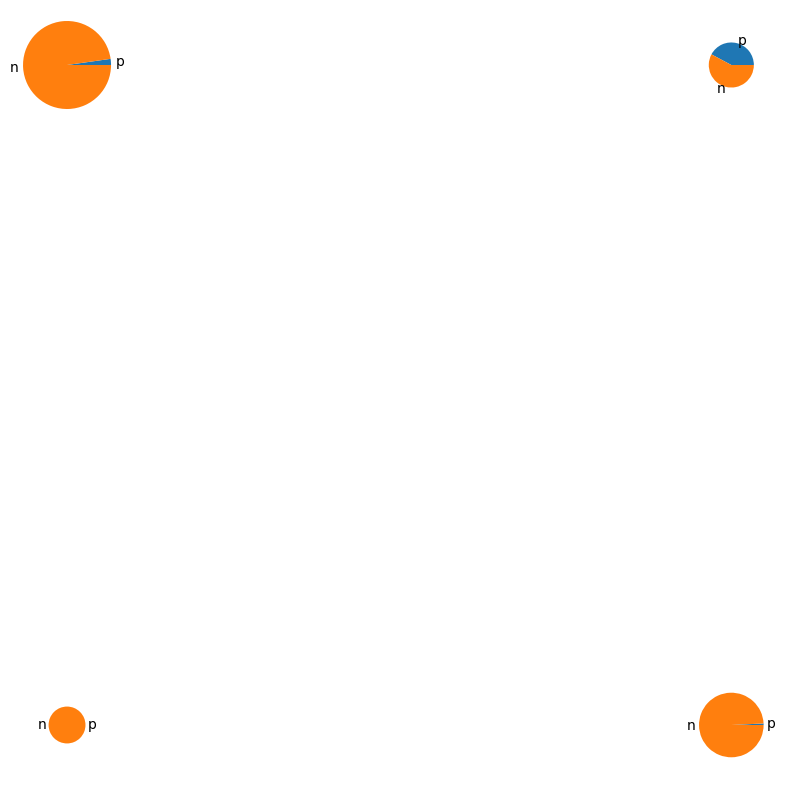

In [30]:
classes_count = best_result['classes_count']
fig,ax = plt.subplots(algo.x,algo.y,figsize=(10,10))
ax = ax.flatten()
sbt = ['p','n']

max_values = max(
    [classes_count[key]['positives']+classes_count[key]['negatives'] for key in classes_count.keys()]
)

for idx, res in enumerate(classes_count):
    p = classes_count[idx]['positives']
    n = classes_count[idx]['negatives']
    if p == 0 and n==0:
        p=None
        n=None

    if (p is None) and (n is None):
        ax[idx].axis('off')
    else:
        ax[idx].pie([p,n],labels=sbt,radius = (p+n)/max_values)

In [34]:
algo.sigma_0

3.9540613738935653